# Using behavioural theories in the knowledge extraction from the energy consumption of private households

## Import packages and load csv files

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file = 'acorn_details.csv'
acorn = pd.read_csv(file)

In [3]:
file2= 'informations_households.csv'
households = pd.read_csv(file2)

In [4]:
file3= './daily_dataset.csv/daily_dataset.csv'
daily = pd.read_csv(file3)

## Households dataset preprocessing

In [5]:
# Change Datatpyes
households['stdorToU'] = households['stdorToU'].astype('category')
households['LCLid'] = households['LCLid'].astype('category')
households['Acorn'] = households['Acorn'].astype('category')

In [6]:
households.isnull().sum() # There are no missing values

LCLid            0
stdorToU         0
Acorn            0
Acorn_grouped    0
file             0
dtype: int64

In [7]:
households = households.drop(columns=['Acorn_grouped','file'])

## Daily dataset

In [8]:
# Change datatypes from object to category
daily['LCLid'] = daily['LCLid'].astype('category')

# Change day to pandas datetime format
daily['Date'] = pd.to_datetime(daily['day'])
daily = daily.drop(columns=['day'])

# Change numerical datatypes to float32
num_vars = daily.select_dtypes(include=np.float64).columns
daily[num_vars] = daily[num_vars].astype(np.float32)

In [9]:
print("Missing values:\n",daily.isna().sum()) # there are Missing values in the daily dataset

# Drop all rows that have an energy_count less than 48 to make them comparable
print("Energy_count less than 48 times a day:\n", daily.loc[daily["energy_count"] <48].count())
daily = daily.drop(daily[daily.energy_count < 48].index)
daily = daily.reset_index(drop=True)

print("Missing values after cleaning:\n",daily.isnull().sum()) # no more missing values in the dataset

Missing values:
 LCLid                0
energy_median       30
energy_mean         30
energy_max          30
energy_count         0
energy_std       11331
energy_sum          30
energy_min          30
Date                 0
dtype: int64
Energy_count less than 48 times a day:
 LCLid            41081
energy_median    41051
energy_mean      41051
energy_max       41051
energy_count     41081
energy_std       29750
energy_sum       41051
energy_min       41051
Date             41081
dtype: int64
Missing values after cleaning:
 LCLid            0
energy_median    0
energy_mean      0
energy_max       0
energy_count     0
energy_std       0
energy_sum       0
energy_min       0
Date             0
dtype: int64


Text(0.5, 0, 'Date')

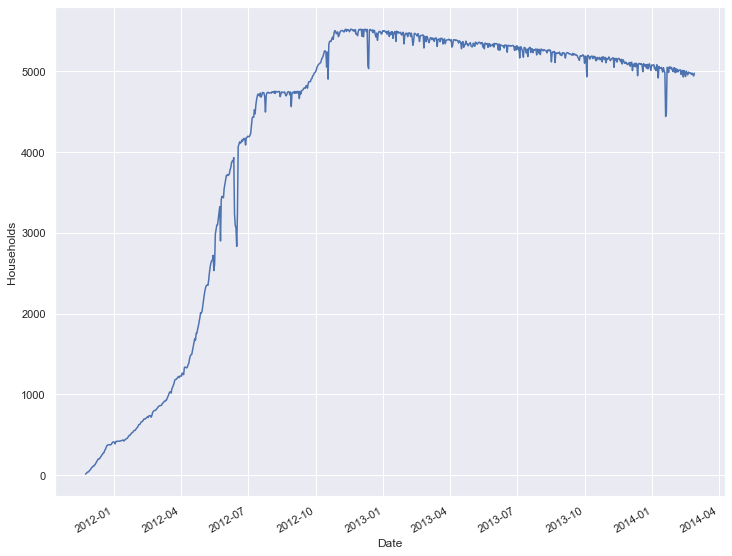

In [10]:
sns.set(style="darkgrid")
day_count = daily['Date'].value_counts()
plt.figure(figsize=(12, 10))
day_count.plot(x='Date',y='LCLid')
plt.ylabel('Households', fontsize=12)
plt.xlabel('Date', fontsize=12)

The plot shows that the most data is available in 2013, hence this timespan will be used for the data analysis

In [11]:
# only keep 2013
daily['year'] = pd.DatetimeIndex(daily['Date']).year
daily = daily.drop(daily[daily.year != 2013].index)
daily =daily.drop('year',1)

In [12]:
# Delete households with no energy consumption all year

countEnergy_sum = daily.groupby('LCLid').agg({'energy_sum':'sum'}) # Energy consumption in total by each household

countEnergy_sum = countEnergy_sum.loc[countEnergy_sum['energy_sum']>0] # Energy consumption in total by each household higher than 0
countEnergy_sum.reset_index(inplace=True) # reset index

daily = pd.merge(daily, countEnergy_sum, how='inner', on ='LCLid') #only households which have more than energy consumption 0 in total

daily = daily.drop(columns='energy_sum_y')
daily.rename({'energy_sum_x': 'energy_sum'}, axis=1, inplace=True)

In [13]:
# The median of the LCLids over the year 2013 is 363
# which means that the most households that paricipated provided their smart meter data for 363 days
print(daily['LCLid'].value_counts().median())

daily['LCLid'].value_counts().loc[lambda x : x < daily['LCLid'].value_counts().median()]

363.0


MAC003991    362
MAC000657    362
MAC004403    362
MAC002748    362
MAC000708    362
            ... 
MAC003627      0
MAC002110      0
MAC001300      0
MAC001633      0
MAC003346      0
Name: LCLid, Length: 2040, dtype: int64

In [14]:
# All LCLid's which have less than 360 values per year are dropped to make the households better comparable
countsLCLid = daily['LCLid'].value_counts()

daily = daily[~daily['LCLid'].isin(countsLCLid[countsLCLid < 360].index)]

daily['LCLid'] = daily.LCLid.cat.remove_unused_categories() #Remove unused Categories

<AxesSubplot:>

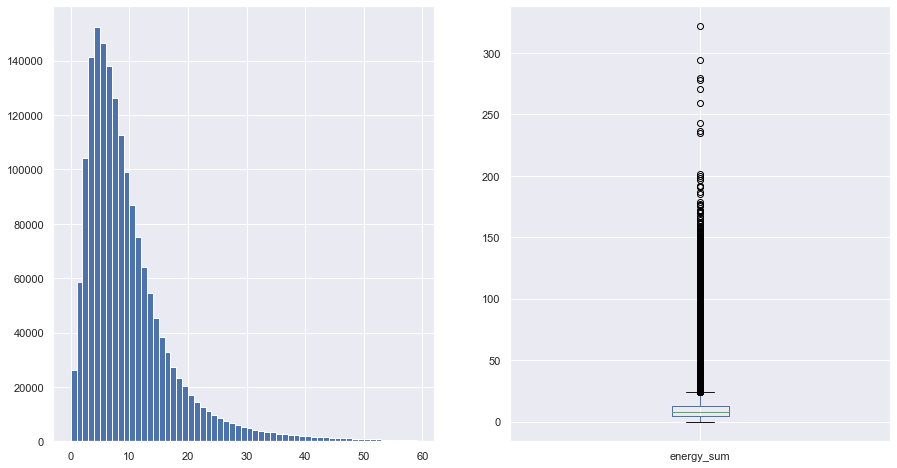

In [15]:
plt.subplot(1, 2, 1)
daily.energy_sum.hist(bins=range(0, 60),figsize=(15, 8))

plt.subplot(1, 2, 2)
daily.energy_sum.plot(kind = 'box')

#plt.savefig('OutliersEnergy_sum.png')

In [16]:
pd.options.display.float_format = "{:.3f}".format
daily.describe()

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
count,1730816.000,1730816.000,1730816.000,1730816.000,1730816.000,1730816.000,1730816.000
mean,0.158,0.210,0.828,48.000,0.171,10.082,0.059
std,0.168,0.189,0.658,0.000,0.151,9.051,0.084
min,0.000,0.000,0.000,48.000,0.000,0.000,0.000
25%,0.067,0.097,0.345,48.000,0.068,4.673,0.020
50%,0.113,0.162,0.685,48.000,0.131,7.771,0.039
75%,0.190,0.260,1.119,48.000,0.226,12.468,0.070
max,6.744,6.702,10.761,48.000,3.165,321.697,5.842


In [17]:
# Outlier truncation 

# Households were energy_sum is bigger than 50 kWh
energy_sum_over_50 = daily.loc[daily['energy_sum']>50]
energy_sum_over_50 = energy_sum_over_50.drop(columns=['energy_median','energy_mean','energy_max','energy_count','energy_std','energy_min'] )

daily_agg = daily.groupby(['LCLid']).agg(
    energy_sum_median_2013 = pd.NamedAgg(column='energy_sum', aggfunc='median')
)

merged_outliers = pd.merge(energy_sum_over_50,daily_agg,on='LCLid')

# new value of energy_sum
# it is proved if the median of all energy_sums of the household also is very high. 
# If it is lower than the day were energy_sum was over 50 it is an outlier.
# Those energy_sums are adjusted to the energy_sum median of this specific household
# Households that have a generally high energy_sum are not considered outliers
merged_outliers['energy_sum'] =np.where(merged_outliers["energy_sum"] > merged_outliers["energy_sum_median_2013"], 
                                  merged_outliers["energy_sum_median_2013"],
                                  merged_outliers["energy_sum"])

# the new energy sum is applied to the original dataframe
daily = pd.merge(daily, merged_outliers, on=["LCLid", "Date"], how='left')

daily['energy_sum'] =np.where(daily["energy_sum_y"].notna(), 
                                  daily["energy_sum_y"],
                                  daily['energy_sum_x'])

cols = [1,2,3,4,5,6,7,9,10]
daily.drop(daily.columns[cols],axis=1,inplace=True)

<AxesSubplot:>

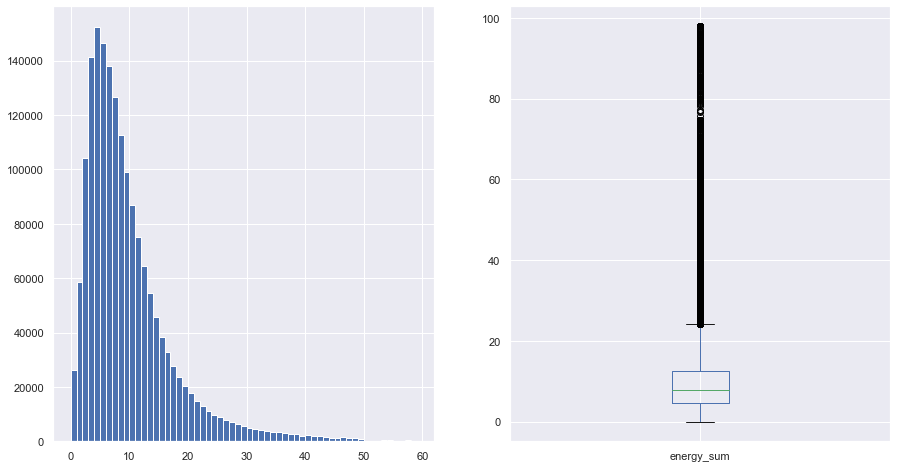

In [18]:
#Histogram and boxplot after outlier truncation
plt.subplot(1, 2, 1)
daily.energy_sum.hist(bins=range(0, 60),figsize=(15, 8))

plt.subplot(1, 2, 2)
daily.energy_sum.plot(kind = 'box')


## Merged Dataset households & daily

In [19]:
#Merge the 2 DF households and daily
energy_consumption = pd.merge(households, daily, on=['LCLid'])

In [20]:
energy_consumption['LCLid'] = energy_consumption['LCLid'].astype('category')

In [21]:
energy_consumption.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1730816 entries, 0 to 1730815
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   LCLid       category      
 1   stdorToU    category      
 2   Acorn       category      
 3   Date        datetime64[ns]
 4   energy_sum  float32       
dtypes: category(3), datetime64[ns](1), float32(1)
memory usage: 39.8 MB


In [22]:
energy_consumption['Acorn'] = energy_consumption.Acorn.cat.remove_unused_categories()
energy_consumption['LCLid'] = energy_consumption.LCLid.cat.remove_unused_categories()

C:\Users\Katja\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Households per Acorn group')

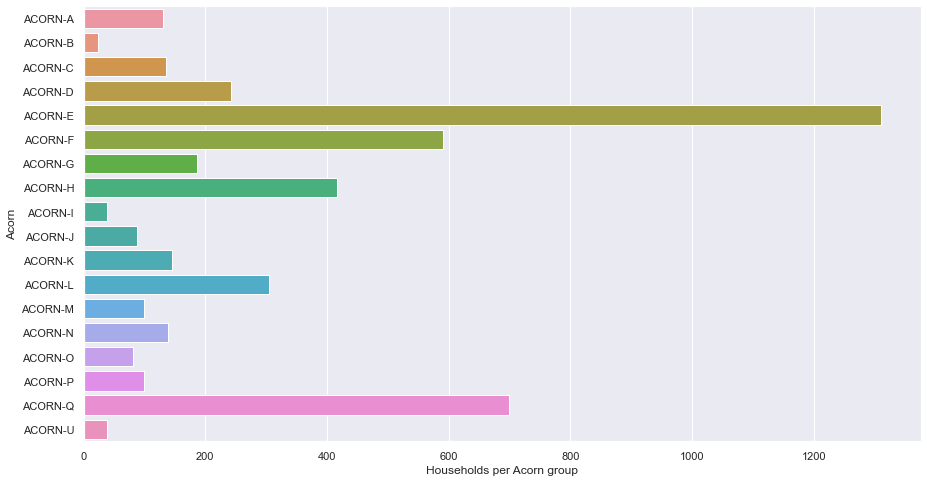

In [23]:
sns.set(rc = {'figure.figsize':(15,8)}, font_scale=1.5)
acorn_count = energy_consumption.groupby('Acorn')['LCLid'].nunique()
sns.set_theme(style="darkgrid")
sns.barplot(acorn_count.values, acorn_count.index)
plt.xlabel('Households per Acorn group')

In [24]:
energy_consumption.groupby('Acorn')['LCLid'].nunique()

Acorn
ACORN-A     130
ACORN-B      23
ACORN-C     136
ACORN-D     242
ACORN-E    1310
ACORN-F     590
ACORN-G     187
ACORN-H     416
ACORN-I      39
ACORN-J      87
ACORN-K     145
ACORN-L     304
ACORN-M      99
ACORN-N     138
ACORN-O      81
ACORN-P     100
ACORN-Q     699
ACORN-U      38
Name: LCLid, dtype: int64

In [25]:
# There are 4298 distinct households
energy_consumption.groupby('LCLid').ngroups

4764

In [26]:
energy_consumption['Acorn'].value_counts().median()

49784.5

In [27]:
energy_consumption.groupby('Acorn')['LCLid'].nunique().loc[lambda x : x < 130]

Acorn
ACORN-B     23
ACORN-I     39
ACORN-J     87
ACORN-M     99
ACORN-O     81
ACORN-P    100
ACORN-U     38
Name: LCLid, dtype: int64

In [28]:
energy_consumption['Acorn'].value_counts().loc[lambda x : x < 49423]

ACORN-A    47206
ACORN-P    36355
ACORN-M    35965
ACORN-J    31609
ACORN-O    29408
ACORN-I    14162
ACORN-U    13811
ACORN-B     8367
Name: Acorn, dtype: int64

In [29]:
#Drop all Acorns that have less than 47000 contributions
countsAcorn = energy_consumption['Acorn'].value_counts()

energy_consumption = energy_consumption[~energy_consumption['Acorn'].isin(countsAcorn[countsAcorn < 47000].index)]

In [30]:
energy_consumption = energy_consumption[energy_consumption['energy_sum'].notnull()]

In [31]:
# Remove unused categories
energy_consumption['Acorn'] = energy_consumption.Acorn.cat.remove_unused_categories()
energy_consumption['LCLid'] = energy_consumption.LCLid.cat.remove_unused_categories()

## Acorn Dataset

In [32]:
# Drop acorns that are not used
acorn = acorn.drop(columns=['ACORN-B', 'ACORN-I','ACORN-B', 'ACORN-J','ACORN-M','ACORN-P','ACORN-O'])

In [33]:
# Change the variables to save storage
# object variables are changed to categorical variables
acorn['MAIN CATEGORIES'] = acorn['MAIN CATEGORIES'].astype('category')
acorn['CATEGORIES'] = acorn['CATEGORIES'].astype('category')
acorn['REFERENCE'] = acorn['REFERENCE'].astype('category')

# float64 variables are comprimised to float32
num_vars_acorn = acorn.select_dtypes(include=np.float64).columns
acorn[num_vars_acorn] = acorn[num_vars_acorn].astype(np.float32)

In [34]:
# See what kind of Categories exist
categories = acorn.groupby("MAIN CATEGORIES")
categories.first()

,CATEGORIES,REFERENCE,ACORN-A,ACORN-C,ACORN-D,ACORN-E,ACORN-F,ACORN-G,ACORN-H,ACORN-K,ACORN-L,ACORN-N,ACORN-Q
MAIN CATEGORIES,,,,,,,,,,,,,
COMMUNITY SAFETY,Crime Survey for England,Too lenient sentencing,75.000,100.000,57.000,80.000,110.000,109.000,114.000,51.000,106.000,114.000,101.000
CONTACT,Preferred Channel,Email,137.000,160.000,73.000,73.000,214.000,84.000,85.000,60.000,50.000,57.000,74.000
DIGITAL,Internet Access: Frequency,Weekly,113.000,104.000,118.000,114.000,103.000,107.000,104.000,116.000,99.000,74.000,89.000
ECONOMY,Economic Activity,Employee Full-Time,93.000,96.000,128.000,128.000,91.000,107.000,110.000,78.000,100.000,74.000,76.000
EDUCATION,Highest Level of Qualifications (Adults),No formal qualifications,49.000,84.000,58.000,66.000,96.000,90.000,97.000,68.000,120.000,157.000,146.000
ENVIRONMENT,Environmental Groups,Member of Environmental Group,138.000,129.000,155.000,135.000,108.000,112.000,79.000,119.000,66.000,64.000,56.000
FAMILY,Structure,Couple family no children,112.000,113.000,115.000,118.000,132.000,108.000,104.000,83.000,90.000,69.000,62.000
FINANCE,Household Annual Income,"�0-�20,000",19.000,65.000,43.000,55.000,78.000,60.000,73.000,115.000,111.000,219.000,218.000
HEALTH,Behaviours & Lifestyle,Current cigarette smoker,38.000,52.000,82.000,84.000,79.000,83.000,83.000,122.000,115.000,140.000,200.000


In [35]:
# function for outlier truncation of acorns
# all acorn features are not supposed to be higher than 1000
def truncate_acorn(column):
    acorn.loc[acorn.iloc[:,column]>1000,acorn.columns[column]] =  1000

In [36]:
truncate_acorn(3)
truncate_acorn(4)
truncate_acorn(5)
truncate_acorn(6)
truncate_acorn(7)
truncate_acorn(8)
truncate_acorn(9)
truncate_acorn(10)
truncate_acorn(11)
truncate_acorn(12)
truncate_acorn(13)

In [37]:
# Create DF with MAIN CATEGORY only so the Outlier truncation can be made more specifically for each category

environment = acorn["MAIN CATEGORIES"] == "ENVIRONMENT"
environment = acorn[environment]

family = acorn["MAIN CATEGORIES"] == "FAMILY"
family = acorn[family]

housing = acorn["MAIN CATEGORIES"] == "HOUSING"
housing = acorn[housing]

education = acorn["MAIN CATEGORIES"] == "EDUCATION"
education = acorn[education]

### Environment

In [38]:
# Drop unnecessary columns 
environment = environment.drop(columns=['MAIN CATEGORIES', 'CATEGORIES'])
environment = environment.reset_index()
environment = environment.drop(columns="index")

# Transpose the dataframe so it is easier to show the plots 
environment_transposed = environment.T

environment_transposed = environment_transposed.rename(columns=environment_transposed.iloc[0]).drop(environment_transposed.index[0]) #set References as new header
environment_transposed.reset_index(inplace=True) #reset index 
environment_transposed = environment_transposed.rename(columns={'index': 'Acorn'}) #rename the column with Acorns

In [39]:
# Change Datatypes 
environment_transposed['Acorn'] = environment_transposed['Acorn'].astype('category')
obj_vars = environment_transposed.select_dtypes(include=np.object).columns
environment_transposed[obj_vars] = environment_transposed[obj_vars].astype(np.float32)

In [40]:
# Give columns shorter names
dict = {'Member of Environmental Group': 'Member_Environmental_Group',
        'Rarely Leave TV or PC on standby for long periods of time at home': 'Rarely_Leave_TV_or_PC_on_standby',
        'Rarely keep the tap running while brushing teeth': 'Rarely_keep_tap_running',
        'Rarely leave the heating on when out for a few hours': 'Rarely_leave_heating_on_when_out',
       'Decide not to buy something because it has too much packaging': 'Dont_buy_something_because_of_too_much_packaging',
       'Take own shopping bag when shopping': 'Take_own_shopping_bag_when_shopping ',
       'Re-use items like empty bottles, tubs, jars, envelopes or paper': 'Re_use_items',
       'Rarely leave the mobile phone charger in the socket when not in use': 'Rarely_leave__phone_charger_in_socket',
       'Recycle items rather than throwing them away': 'Recycle_items_rather_than_throwing_away',
       'Make an effort to cut down on the use of gas/electricity at home': 'effort_to_conserve_gas_electricity_at_home',
       'Make an effort to cut down on water usage at home': 'effort_to_conserve_water_at_home',
       'There is too much concern with the environment: Agree': 'There_is_too_much_concern_with_the_environment'}
  

environment_transposed.rename(columns=dict,
          inplace=True)

### Education

In [41]:
education["REFERENCE"] = education["CATEGORIES"].astype(str) + education["REFERENCE"].astype(str)

<ipython-input-41-a5897a51586d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  education["REFERENCE"] = education["CATEGORIES"].astype(str) + education["REFERENCE"].astype(str)


In [42]:
# Drop unnecessary columns 
education = education.drop(columns=['MAIN CATEGORIES', 'CATEGORIES'])

In [43]:
# Transpose the dataframe so it can be merged with the other datasets
education_transposed = education.T

education_transposed = education_transposed.rename(columns=education_transposed.iloc[0]).drop(education_transposed.index[0]) #set References as new header
education_transposed.reset_index(inplace=True) #reset index 
education_transposed = education_transposed.rename(columns={'index': 'Acorn'}) #rename the column with Acorns

# Change Datatypes 
education_transposed['Acorn'] = education_transposed['Acorn'].astype('category')
obj_vars = education_transposed.select_dtypes(include=np.object).columns
education_transposed[obj_vars] = education_transposed[obj_vars].astype(np.float32)

In [44]:
# Give columns shorter names
dict = {'Highest Level of Qualifications (Adults)No formal qualifications': 'Adults_No_formal_qualifications',
        'Highest Level of Qualifications (Adults)GCSE / O levels / CSE / School Certificate': 'Adults_GCSE_O_levels_CSE_School Certificate',
        'Highest Level of Qualifications (Adults)ONC / BTEC / apprenticeship': 'Adults_ONC_BTEC_apprenticeship',
        'Highest Level of Qualifications (Adults)A-levels/ AS levels or Highers': 'Adults_A_levels_AS_levels_or_Highers',
        'Highest Level of Qualifications (Adults)Higher education below degree level':'Adults_Higher education below degree level',
       'Highest Level of Qualifications (Adults)Degree or higher degree': 'Adults_Degree_or_higher_degree'}

education_transposed.rename(columns=dict,
          inplace=True)

### Housing

In [45]:
# Drop unnecessary columns 
housing = housing.drop(columns=['MAIN CATEGORIES', 'CATEGORIES'])

In [46]:
# Transpose the dataframe so it can be merged with the other datasets
housing_transposed = housing.T

housing_transposed = housing_transposed.rename(columns=housing_transposed.iloc[0]).drop(housing_transposed.index[0]) #set References as new header
housing_transposed.reset_index(inplace=True) #reset index 
housing_transposed = housing_transposed.rename(columns={'index': 'Acorn'}) #rename the column with Acorns

In [47]:
cols = [1,2,3,4,5]
housing_transposed.drop(housing_transposed.columns[cols],axis=1,inplace=True)

In [48]:
# Give columns shorter names
dict = {'Owner occupied': 'Owner_occupied',
        'Owned outright': 'Owned_outright',
        'Privately rented': 'Privately_rented',
        'Social renting': 'Social_renting',
       'Shared/Equity Ownership': 'SharedEquity_Ownership',
       'House Value up to 100k': 'HV_up_to_100k',
       'House Value 100k-150k': 'HV_100k_150k',
       'House Value 150k-250k': 'HV_150k_250k',
       'House Value 250k-500k': 'HV_250k_500k',
       'House Value 500k-750k': 'HV_500k_750k',
        'House Value 750k-1m': 'HV_750k_1m',
       'House Value 1m+': 'HV_1m',
       'Number of Beds : 1':'No_Beds_1',
       'Number of Beds : 2':'No_Beds_2',
       'Number of Beds : 3':'No_Beds_3',
       'Number of Beds : 4':'No_Beds_4',
       'Number of Beds : 5 plus':'No_Beds_5pl'}
  

housing_transposed.rename(columns=dict,
          inplace=True)

## Plots

[Text(0, 0.5, 'Mean energy consumption')]

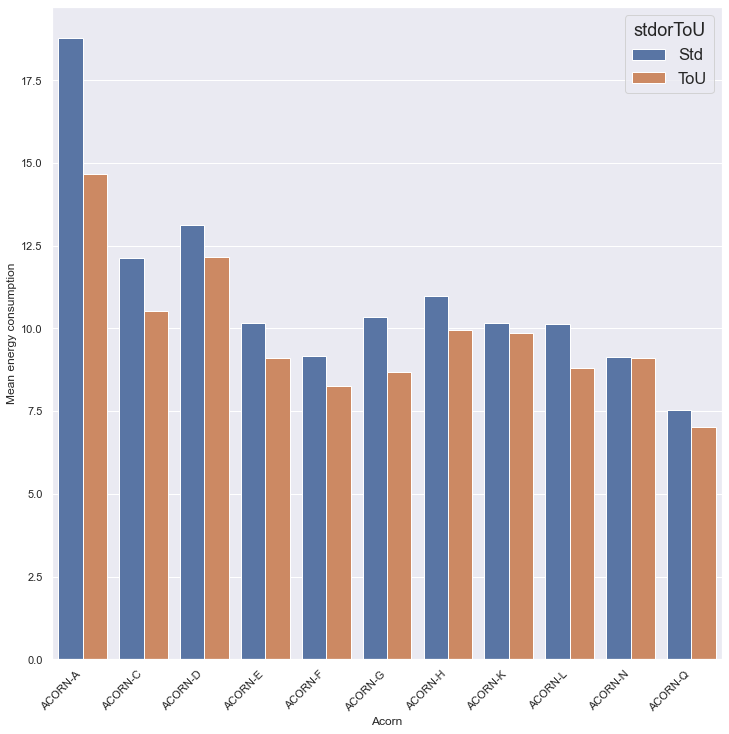

In [49]:
aggdata = energy_consumption.groupby(['Acorn','stdorToU'])['energy_sum'].agg('mean').reset_index()
fig,ax = plt.subplots(figsize = (12,12))
sns.set(font_scale=1.5)  

bp = sns.barplot(ax = ax,x = 'Acorn',y = 'energy_sum',hue = 'stdorToU',data =aggdata)
bp.set_xticklabels(bp.get_xticklabels(), 
      rotation=45, 
      horizontalalignment='right')
ax.set(ylabel='Mean energy consumption')

In [50]:
#To account for the variation in measurements we will normalise to the number of LCLid, using the normalisation approach
sum_y2013_df = pd.concat([energy_consumption.groupby("Acorn").sum()["energy_sum"], energy_consumption.groupby("Acorn").count()["LCLid"]], axis=1)
sum_y2013_df["normalised"] = sum_y2013_df["energy_sum"] / sum_y2013_df["LCLid"]
sum_y2013_df

,energy_sum,LCLid,normalised
Acorn,,,
ACORN-A,840042.812,47206,17.795
ACORN-C,582448.188,49423,11.785
ACORN-D,1132590.875,87979,12.873
ACORN-E,4727253.000,475990,9.931
ACORN-F,1921076.250,214243,8.967
ACORN-G,676476.250,67950,9.956
ACORN-H,1633977.125,151246,10.803
ACORN-K,532490.125,52660,10.112
ACORN-L,1087109.875,110472,9.841


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'ACORN-A'),
  Text(1, 0, 'ACORN-C'),
  Text(2, 0, 'ACORN-D'),
  Text(3, 0, 'ACORN-E'),
  Text(4, 0, 'ACORN-F'),
  Text(5, 0, 'ACORN-G'),
  Text(6, 0, 'ACORN-H'),
  Text(7, 0, 'ACORN-K'),
  Text(8, 0, 'ACORN-L'),
  Text(9, 0, 'ACORN-N'),
  Text(10, 0, 'ACORN-Q')])

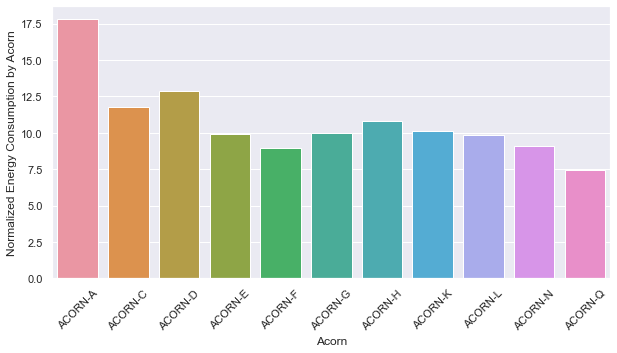

In [69]:
sns.set_theme(style="darkgrid")
sns.barplot(data=sum_y2013_df, x=sum_y2013_df.index, y='normalised')
plt.ylabel("Normalized Energy Consumption by Acorn")
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'ACORN-A'),
  Text(1, 0, 'ACORN-C'),
  Text(2, 0, 'ACORN-D'),
  Text(3, 0, 'ACORN-E'),
  Text(4, 0, 'ACORN-F'),
  Text(5, 0, 'ACORN-G'),
  Text(6, 0, 'ACORN-H'),
  Text(7, 0, 'ACORN-K'),
  Text(8, 0, 'ACORN-L'),
  Text(9, 0, 'ACORN-N'),
  Text(10, 0, 'ACORN-Q')])

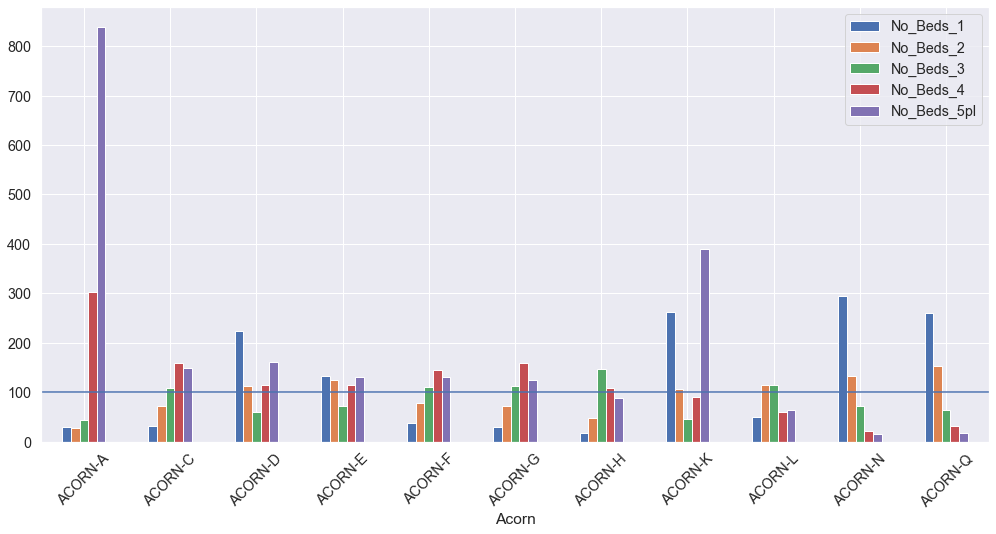

In [61]:
housing_transposed.plot(x = "Acorn",              
             y=["No_Beds_1","No_Beds_2", "No_Beds_3", "No_Beds_4", "No_Beds_5pl"], 
             kind="bar",
             figsize=(17,8))
plt.axhline(100)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'ACORN-A'),
  Text(1, 0, 'ACORN-C'),
  Text(2, 0, 'ACORN-D'),
  Text(3, 0, 'ACORN-E'),
  Text(4, 0, 'ACORN-F'),
  Text(5, 0, 'ACORN-G'),
  Text(6, 0, 'ACORN-H'),
  Text(7, 0, 'ACORN-K'),
  Text(8, 0, 'ACORN-L'),
  Text(9, 0, 'ACORN-N'),
  Text(10, 0, 'ACORN-Q')])

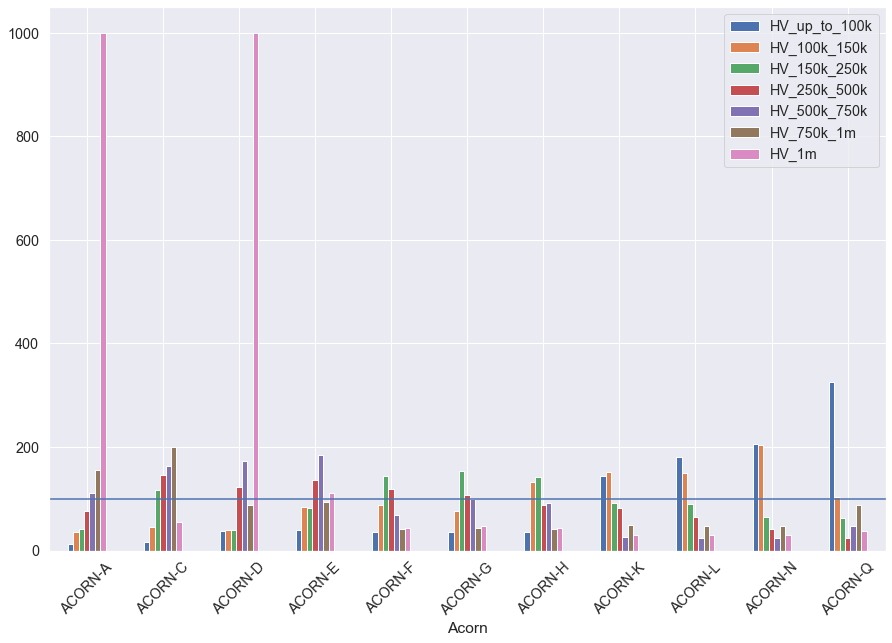

In [60]:
housing_transposed.plot(x = "Acorn", 
             y=["HV_up_to_100k","HV_100k_150k", "HV_150k_250k", "HV_250k_500k", "HV_500k_750k","HV_750k_1m", "HV_1m"], 
             kind="bar",
             figsize=(15,10))
plt.axhline(100)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'ACORN-A'),
  Text(1, 0, 'ACORN-C'),
  Text(2, 0, 'ACORN-D'),
  Text(3, 0, 'ACORN-E'),
  Text(4, 0, 'ACORN-F'),
  Text(5, 0, 'ACORN-G'),
  Text(6, 0, 'ACORN-H'),
  Text(7, 0, 'ACORN-K'),
  Text(8, 0, 'ACORN-L'),
  Text(9, 0, 'ACORN-N'),
  Text(10, 0, 'ACORN-Q')])

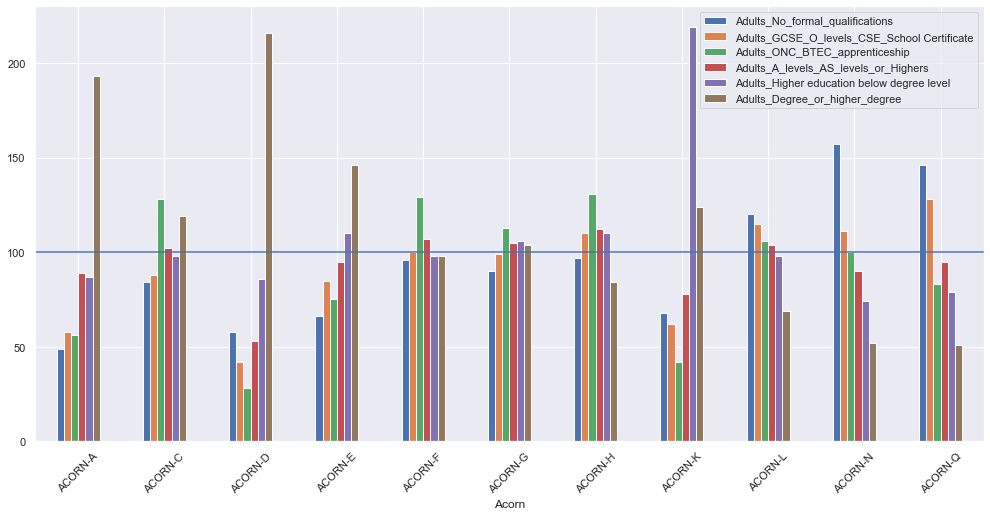

In [54]:
education_transposed.plot(x = "Acorn",              
             y=["Adults_No_formal_qualifications", "Adults_GCSE_O_levels_CSE_School Certificate", "Adults_ONC_BTEC_apprenticeship", "Adults_A_levels_AS_levels_or_Highers","Adults_Higher education below degree level","Adults_Degree_or_higher_degree"], 
             kind="bar",
             figsize=(17,8))
plt.axhline(100)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'ACORN-A'),
  Text(1, 0, 'ACORN-C'),
  Text(2, 0, 'ACORN-D'),
  Text(3, 0, 'ACORN-E'),
  Text(4, 0, 'ACORN-F'),
  Text(5, 0, 'ACORN-G'),
  Text(6, 0, 'ACORN-H'),
  Text(7, 0, 'ACORN-K'),
  Text(8, 0, 'ACORN-L'),
  Text(9, 0, 'ACORN-N'),
  Text(10, 0, 'ACORN-Q')])

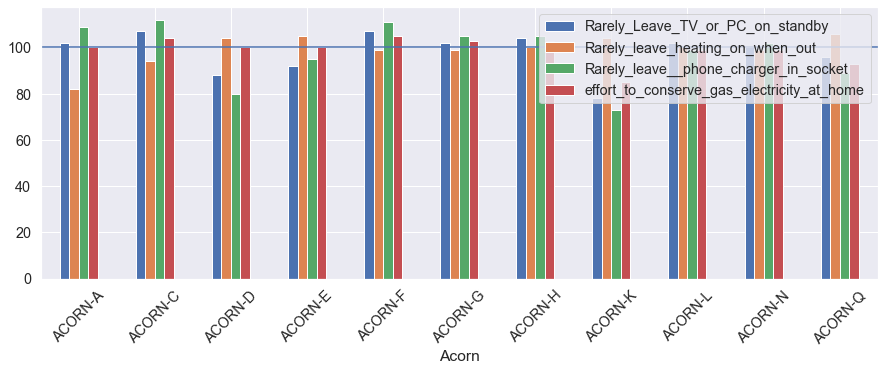

In [62]:
environment_transposed.plot(x = "Acorn", 
             y=["Rarely_Leave_TV_or_PC_on_standby","Rarely_leave_heating_on_when_out", "Rarely_leave__phone_charger_in_socket", "effort_to_conserve_gas_electricity_at_home"], 
             kind="bar",
             figsize=(15,5))
plt.axhline(100)
plt.xticks(rotation=45)

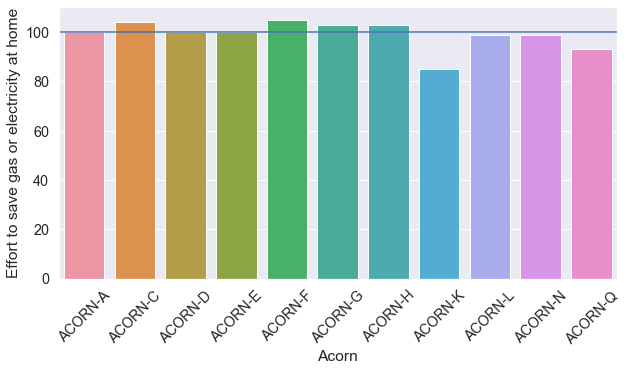

In [66]:
sns.set(rc = {'figure.figsize':(10,5)}, font_scale=1.3)
ax = sns.barplot(x="Acorn", 
                 y="effort_to_conserve_gas_electricity_at_home", 
                 data=environment_transposed)
ax.set(ylabel='Effort to save gas or electricity at home')
plt.xticks(rotation=45)
ax.axhline(100)

In [57]:
environment_transposed['avg_energy_conservation_intention']=environment_transposed[['Rarely_Leave_TV_or_PC_on_standby', 'Rarely_leave_heating_on_when_out', 'Rarely_leave__phone_charger_in_socket']].mean(axis=1)

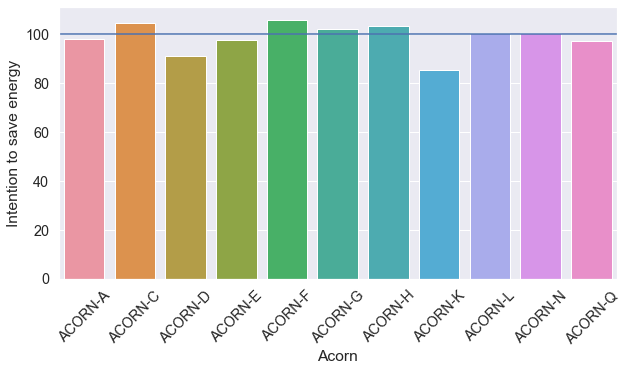

In [67]:
sns.set(rc = {'figure.figsize':(10,5)}, font_scale=1.3)
ax = sns.barplot(x="Acorn", 
                 y="avg_energy_conservation_intention", 
                 data=environment_transposed)
ax.set(ylabel='Intention to save energy')
plt.xticks(rotation=45)
ax.axhline(100)

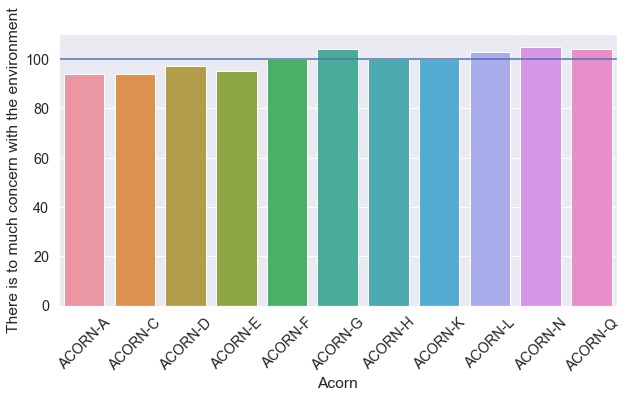

In [68]:
sns.set(rc = {'figure.figsize':(10,5)}, font_scale=1.3)
ax = sns.barplot(x="Acorn", 
                 y="There_is_too_much_concern_with_the_environment", 
                 data=environment_transposed)
ax.set(ylabel='There is to much concern with the environment')
plt.xticks(rotation=45)
ax.axhline(100)